In [1]:
setwd('/import/DB/zhang//data')

library(Seurat)

Warning message:
"package 'Seurat' was built under R version 4.2.3"
The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject



In [2]:
daa = readRDS('./OBcell.final.rds')

In [3]:
table(daa$cellgroup)


 Inter_OB normal_OB  tumor_OB 
     1111       407      1391 

In [4]:
GetData = function(
  srt,
  genes = NULL,
  slot = 'scale.data',
  assay = NULL
){
  if (is.null(assay)){
    assay = DefaultAssay(srt)
  }
  if (is.null(genes)){
    if ('RNA' %in% names(srt@assays)){
      genes = rownames(GetAssayData(srt, assay = 'RNA', slot = 'counts'))
    } else if  ('Spatial' %in% names(srt@assays)){
      genes = rownames(GetAssayData(srt, assay = 'Spatial', slot = 'counts'))
    } else {
      genes = rownames(GetAssayData(srt, assay = assay, slot = 'counts'))
    }
  }
  data = GetAssayData(srt, assay = assay, slot = slot)
  missing = setdiff(genes, rownames(data))
  add = matrix(0, nrow = length(missing), ncol = ncol(data))
  rownames(add) = missing
  data = rbind(data, add)
  data = data[genes, ]
  return(data)
}
NMFToModules = function(
  res,
  gmin = 5
){
  
  scores = basis(res)
  coefs = coefficients(res)
  
  # Remove if fewer than gmin genes
  ranks_x = t(apply(-t(t(scores) / apply(scores, 2, mean)), 1, rank))
  ranks_y = apply(-t(t(scores) / apply(scores, 2, mean)), 2, rank)
  for (i in 1:ncol(scores)){
    ranks_y[ranks_x[,i] > 1,i] = Inf
  }
  modules = apply(ranks_y, 2, function(m){
    a = sort(m[is.finite(m)])
    a = a[a == 1:length(a)]
    names(a)
  })
  l = sapply(modules, length)
  keep = (l >= gmin)
  scores = scores[, keep]
  coefs = coefs[keep, ]
  
  # Find modules
  ranks_x = t(apply(-t(t(scores) / apply(scores, 2, mean)), 1, rank))
  ranks_y = apply(-t(t(scores) / apply(scores, 2, mean)), 2, rank)
  for (i in 1:ncol(scores)){
    ranks_y[ranks_x[,i] > 1,i] = Inf
  }
  modules = apply(ranks_y, 2, function(m){
    a = sort(m[is.finite(m)])
    a = a[a == 1:length(a)]
    names(a)
  })
  
  names(modules) = sapply(modules, '[', 1)
  names(modules) = paste('m', names(modules), sep = '_')
  names(modules) = gsub('-','_',names(modules))
  
  return(modules)
}
BuildEnrichmentMatrix = function(
  genes,
  type = 'GO',
  db = NULL
){
  if (is.null(db)){
    db = FindMSigDB(type)
  }
  terms = names(db)
  enrichment.matrix = sapply(db, function(term){
    genes %in% term
  })
  rownames(enrichment.matrix) = genes
  #enrichment.matrix = enrichment.matrix[, colSums(enrichment.matrix) > 0]
  enrichment.matrix[, colSums(enrichment.matrix) == 0] = NA
  return(enrichment.matrix)
}
FindMSigDB = function(
  type
){
library(msigdbr)
  if (type == 'GO'){
    gene_sets <- msigdbr(species = "Homo sapiens",category = 'C5')%>% dplyr::select(gs_name,human_entrez_gene, gene_symbol)
    db = split(gene_sets$gene_symbol,f = gene_sets$gs_name)
  } else if (type == 'HALLMARK'){
    gene_sets <- msigdbr(species = "Homo sapiens",category = 'H')%>% dplyr::select(gs_name,human_entrez_gene, gene_symbol)
    db = split(gene_sets$gene_symbol,f = gene_sets$gs_name)
  } else if (type == 'MOTIF'){
    gene_sets <- msigdbr(species = "Homo sapiens",category = 'C3')%>% dplyr::select(gs_name,human_entrez_gene, gene_symbol)
    db = split(gene_sets$gene_symbol,f = gene_sets$gs_name)
    db = db[-grep('UNKNOWN|MIR',names(db))]
  } else if (type == 'PATHWAYS'){
    gene_sets <- msigdbr(species = "Homo sapiens",category = 'C2')%>% dplyr::select(gs_name,human_entrez_gene, gene_symbol)
    db = split(gene_sets$gene_symbol,f = gene_sets$gs_name)
    db = db[grep('BIOCARTA|REACTOME|KEGG',names(db))]
  } else if (type == 'BIOCARTA'){
      gene_sets <- msigdbr(species = "Homo sapiens",category = 'C2')%>% dplyr::select(gs_name,human_entrez_gene, gene_symbol)
    db = split(gene_sets$gene_symbol,f = gene_sets$gs_name)
    db = db[grep('BIOCARTA',names(db))]
  } else if (type == 'KEGG'){
    gene_sets <- msigdbr(species = "Homo sapiens",category = 'C2')%>% dplyr::select(gs_name,human_entrez_gene, gene_symbol)
    db = split(gene_sets$gene_symbol,f = gene_sets$gs_name)
    db = db[grep('KEGG',names(db))]
  } else if (type == 'REACTOME'){
    gene_sets <- msigdbr(species = "Homo sapiens",category = 'C2')%>% dplyr::select(gs_name,human_entrez_gene, gene_symbol)
    db = split(gene_sets$gene_symbol,f = gene_sets$gs_name)
    db = db[grep('REACTOME',names(db))]
  } else {
    gene_sets <- msigdbr(species = "Homo sapiens",category = 'C5')%>% dplyr::select(gs_name,human_entrez_gene, gene_symbol)
    db = split(gene_sets$gene_symbol,f = gene_sets$gs_name)
    db = db[grep(type, names(db), ignore.case = TRUE, value = TRUE)]
  }
  return(db)
}
loadRData = function(fileName){
  load(fileName)
  get(ls()[ls() != "fileName"])
}
Heatmap = function(
  matrix,
  colors = NULL,
  breaks = NULL,
  col = NULL,
  clustering_method_rows = 'ward.D2', 
  clustering_method_columns = 'ward.D2',
  clustering_distance_rows = 'pearson',
  clustering_distance_columns = 'pearson',
  show_row_names = FALSE,
  show_column_names = FALSE,
  is.symmetric = FALSE,
  ...
){
  if (is.null(breaks)){
    mi = min(matrix, na.rm = TRUE)
    ma = max(matrix, na.rm = TRUE)
    if (mi < 0 & ma > 0){
      breaks = c(mi, 0, ma)
    } else {
      breaks = c(mi, (mi + ma)/2, ma)
    }
  }
  if (is.null(colors)){
    colors = c('blue','white','red')
  }
  if (is.null(col)){
    col = colorRamp2(breaks = breaks, colors = colors)
  }
  if (is.symmetric == TRUE){
    h = ComplexHeatmap::Heatmap(matrix, 
                                col = col,
                                clustering_method_rows = clustering_method_rows, 
                                clustering_distance_rows = clustering_distance_rows,
                                cluster_columns = FALSE,
                                show_row_names = show_row_names,
                                show_column_names = show_column_names,
                                ...)
    o = unlist(row_order(h))
    return(ComplexHeatmap::Heatmap(matrix, 
                                   col = col,
                                   clustering_method_rows = clustering_method_rows, 
                                   clustering_distance_rows = clustering_distance_rows,
                                   cluster_columns = FALSE,
                                   column_order = o,
                                   show_row_names = show_row_names,
                                   show_column_names = show_column_names, 
                                   ...))
  } else {
    return(ComplexHeatmap::Heatmap(matrix, 
                                   col = col,
                                   clustering_method_rows = clustering_method_rows, 
                                   clustering_method_columns = clustering_method_columns,
                                   clustering_distance_rows = clustering_distance_rows,
                                   clustering_distance_columns = clustering_distance_columns,
                                   show_row_names = show_row_names,
                                   show_column_names = show_column_names,
                                   ...))
  }
  
}
GeneToEnrichment <- function (srt, type = "GO", db = NULL, method = "rand", genes = NULL, 
    assay = NULL, do.rescale = FALSE, min.cells = 0, min.genes = 0, 
    min.var = 0, min.var.rescaled = 0, auc_percentile = 0.05, 
    db_rand = NULL, nrand = 4, nbin = 25, ...) 
{
    if (is.null(assay)) {
        assay = DefaultAssay(srt)
    }
    if (is.null(db)) {
        db = FindMSigDB(type)
    }
    counts = as.matrix(GetData(srt, assay = assay, slot = "counts"))
    genes = rownames(counts)
    genes.expr = rownames(counts)[rowSums(counts) > min.cells]
    if (method == "metagene") {
        data = as.matrix(GetAssayData(srt, assay = assay, slot = "scale.data"))
        db = lapply(db, intersect, genes.expr)
        enrichment.profile = t(sapply(names(db), function(m) {
            colMeans(data[db[[m]], ], na.rm = TRUE)
        }))
        enrichment.profile = enrichment.profile[sapply(names(db), 
            function(x) {
                v = var(enrichment.profile[x, ])
                l = length(db[[x]])
                return(l > min.genes && v > min.var && v * l^2 > 
                  min.var.rescaled)
            }), ]
        if (do.rescale) {
            mn = apply(enrichment.profile, 1, mean)
            v = apply(enrichment.profile, 1, var)
            enrichment.profile = (enrichment.profile - mn)/sqrt(v)
        }
        srt = AddMetaData(srt, t(enrichment.profile), col.name = rownames(enrichment.profile))
    }
    if (method == "auc") {
        data = as.matrix(GetData(srt, assay = assay, slot = "data"))
        cells_rankings = AUCell_buildRankings(data)
        cells_AUC = AUCell_calcAUC(db, cells_rankings, aucMaxRank = nrow(cells_rankings) * 
            auc_percentile)
        enrichment.profile = getAUC(cells_AUC)
        if (do.rescale) {
            mn = apply(enrichment.profile, 1, mean)
            v = apply(enrichment.profile, 1, var)
            enrichment.profile = (enrichment.profile - mn)/sqrt(v)
        }
        srt = AddMetaData(srt, t(enrichment.profile), col.name = rownames(enrichment.profile))
    }
    if (method == "score") {
        temp = AddModuleScore(srt, features = db, assay = assay, 
            name = names(db), nbin = nbin, ...)
        enrichment.profile = t(temp@meta.data[, names(db)])
        if (do.rescale) {
            mn = apply(enrichment.profile, 1, mean)
            v = apply(enrichment.profile, 1, var)
            enrichment.profile = (enrichment.profile - mn)/sqrt(v)
        }
        srt = AddMetaData(srt, t(enrichment.profile), col.name = rownames(enrichment.profile))
    }
    if (method == "rand") {
        data = as.matrix(GetData(srt, assay = assay, slot = "scale.data"))
        db = lapply(db, intersect, genes)
        if (is.null(db_rand)) {
            db_rand = MakeRand(srt, db, nrand = nrand, nbin = nbin)
        }
        else {
            nrand = log10(length(db_rand[[1]]))
        }
        enrichment.profile = t(sapply(names(db), function(m) {
            ra = sapply(db_rand[[m]], function(i) {
                colMeans(data[i, ], na.rm = TRUE)
            })
            re = colMeans(data[db[[m]], ], na.rm = TRUE)
            p = rowMeans(ra >= re)
            p = -log10(p)
            return(p)
        }))
        enrichment.profile[is.infinite(enrichment.profile)] = nrand
        enrichment.profile = enrichment.profile/nrand
        srt = AddMetaData(srt, t(enrichment.profile), col.name = rownames(enrichment.profile))
    }
    return(srt)
}
MakeRand <-function (srt, db, assay = NULL, nrand = 3, nbin = 25) 
{
    if (is.null(assay)) {
        assay = DefaultAssay(srt)
    }
    data = GetData(srt, slot = "data")
    db = lapply(db, intersect, rownames(data))
    data.avg = sort(rowMeans(x = data))
    data.cut = cut_number(x = data.avg + rnorm(n = length(data.avg))/1e+30, 
        n = nbin, labels = FALSE, right = FALSE)
    names(x = data.cut) = names(x = data.avg)
    binned = split(names(data.cut), data.cut)
    db_rand = lapply(names(db), function(m) {
        lapply(1:10^nrand, function(i) {
            used = vector()
            unused = binned
            for (g in db[[m]]) {
                pool = data.cut[g]
                new = sample(unused[[pool]], 1)
                used = c(used, new)
                unused[[pool]] = setdiff(unused[[pool]], new)
            }
            return(used)
        })
    })
    names(db_rand) = names(db)
    return(db_rand)
}

In [5]:
range = 4:12 # 迭代次数
gmin = 5 #最低关联数量
ncores = 5 #运行核数量

In [49]:
DefaultAssay(daa) <- 'RNA'    
malignant_list <- SplitObject(object = daa, split.by = "cellgroup")
saveRDS(malignant_list ,file = "./malignant_list.rds")
malignant_list <- readRDS(file = "./malignant_list.rds")

In [50]:
trajectory_cluster_dir=paste('./',"malignant_RDS",sep="/")
if(!file.exists(trajectory_cluster_dir)){
   dir.create(trajectory_cluster_dir)
}

In [51]:
malignant_list_names <- names(malignant_list)
for(i in malignant_list_names){
    saveRDS(malignant_list[[i]],file = paste0('./malignant_RDS/',i,'_malignant_Seurat.RDS'))
}
saveRDS(malignant_list_names,file='./malignant_list_names.RDS')
malignant_list_names <- readRDS(file='./malignant_list_names.RDS')


In [52]:
trajectory_cluster_dir=paste('./',"sample_list",sep="/")
if(!file.exists(trajectory_cluster_dir)){
   dir.create(trajectory_cluster_dir)
}

In [53]:
path <- "./sample_list/"

In [54]:
path

[1] "./sample_list/"

In [55]:
library(dplyr)


for(i in malignant_list_names) {
    if(i %in% sample_name){
        print(paste0(i, " is already over!"))
        next;
    }
    obj <- readRDS(file = paste0('./malignant_RDS/',i,'_malignant_Seurat.RDS'))
    obj <- SCTransform(obj, return.only.var.genes = TRUE)
    saveRDS(obj,file = paste0('./malignant_RDS/',i,'_malignant_Seurat.RDS'))
    data <- GetAssayData(obj, slot = 'scale.data') %>% as.matrix()
 
    data <- data[VariableFeatures(obj),]
	rm(obj)
	gc()
    data[data < 0] <- 0
    data <- data[apply(data, 1, var) > 0, ]
    res.list <- parallel::mclapply(range, function(r){
        nmf(data, rank = r, nrun = 1, seed = 'ica', method = 'nsNMF')
    }, mc.cores = ncores)
    names(res.list) = range
    saveRDS(res.list,file = paste0(path,i,"res.list.rds"))
	print(paste0(i, " is already over!"))
}

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 12253 by 407

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 407 cells



  |======================================================================| 100%


Found 7 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 12253 genes



  |======================================================================| 100%


Computing corrected count matrix for 12253 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 9.694772 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



[1] "normal_OB is already over!"


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 18426 by 1391

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 1391 cells



  |======================================================================| 100%


Found 99 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 18426 genes



  |======================================================================| 100%


Computing corrected count matrix for 18426 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 36.11799 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



[1] "tumor_OB is already over!"


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 16112 by 1111

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 1111 cells



  |======================================================================| 100%


Found 30 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 16112 genes



  |======================================================================| 100%


Computing corrected count matrix for 16112 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 29.02613 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



[1] "Inter_OB is already over!"


In [56]:
malignant_list <- readRDS("./malignant_list.rds")
path <- "./sample_list/"
res.list_L<- list()
for(i in names(malignant_list)){
    a <- readRDS(paste0(path,i ,"res.list.rds"))
    res.list_L[[i]] <- a
    }
   names(res.list_L) <- names(malignant_list)

In [57]:
library(NMF)

In [58]:
#### 获取最优的NMF聚类rank，提取
modules_L <- list()
res_optima_L <- list()
for (i in 1:length(malignant_list)){ 
    modules.list = lapply(res.list_L[[i]], NMFToModules, gmin = gmin)
    print(sapply(modules.list,length))
    comp = as.numeric(names(modules.list)) - sapply(modules.list, length)
    mi = min(comp)
    r = names(which(comp == mi))
    r = r[length(r)]
    res = res.list_L[[i]][[r]]
    modules = NMFToModules(res, gmin = gmin)   
    modules_L[[i]] <- modules
    res_optima_L[[i]] <- res  
}
saveRDS(object = modules_L,file = "./modules_L.rds")
saveRDS(object = res_optima_L,file = "./res_optima_L.rds")

 4  5  6  7  8  9 10 11 12 
 3  4  4  4  7  7  8 10  9 
 4  5  6  7  8  9 10 11 12 
 4  5  6  7  8  9  9  7 10 
 4  5  6  7  8  9 10 11 12 
 4  5  6  7  8  9 10 11 11 


In [60]:
library(pheatmap)

Warning message:
"package 'pheatmap' was built under R version 4.2.3"


 [1] "normal_OB.m_IGFBP3"    "normal_OB.m_PRSS23"    NA                     
 [4] "normal_OB.m_SFRP4"     NA                      NA                     
 [7] "normal_OB.m_PSMD14"    "normal_OB.m_MT1A"      "normal_OB.m_DPT"      
[10] "tumor_OB.m_MX1"        "tumor_OB.m_SPP1"       "tumor_OB.m_PLPP4"     
[13] "tumor_OB.m_NDUFA4L2"   "tumor_OB.m_CENPF"      "tumor_OB.m_AC005532.1"
[16] "tumor_OB.m_ASPN"       "tumor_OB.m_EDNRA"      "Inter_OB.m_IGFBP3"    
[19] "Inter_OB.m_MMP13"      "Inter_OB.m_COMP"       NA                     
[22] "Inter_OB.m_GSTA1"      "Inter_OB.m_TAGLN"      "Inter_OB.m_RGS16"     
[1] 24
 [1] "normal_OB.m_IGFBP3"    "normal_OB.m_PRSS23"    "normal_OB.m_SFRP4"    
 [4] "normal_OB.m_PSMD14"    "normal_OB.m_MT1A"      "normal_OB.m_DPT"      
 [7] "tumor_OB.m_MX1"        "tumor_OB.m_SPP1"       "tumor_OB.m_PLPP4"     
[10] "tumor_OB.m_NDUFA4L2"   "tumor_OB.m_CENPF"      "tumor_OB.m_AC005532.1"
[13] "tumor_OB.m_ASPN"       "tumor_OB.m_EDNRA"      "Inter_OB.m_IGFB

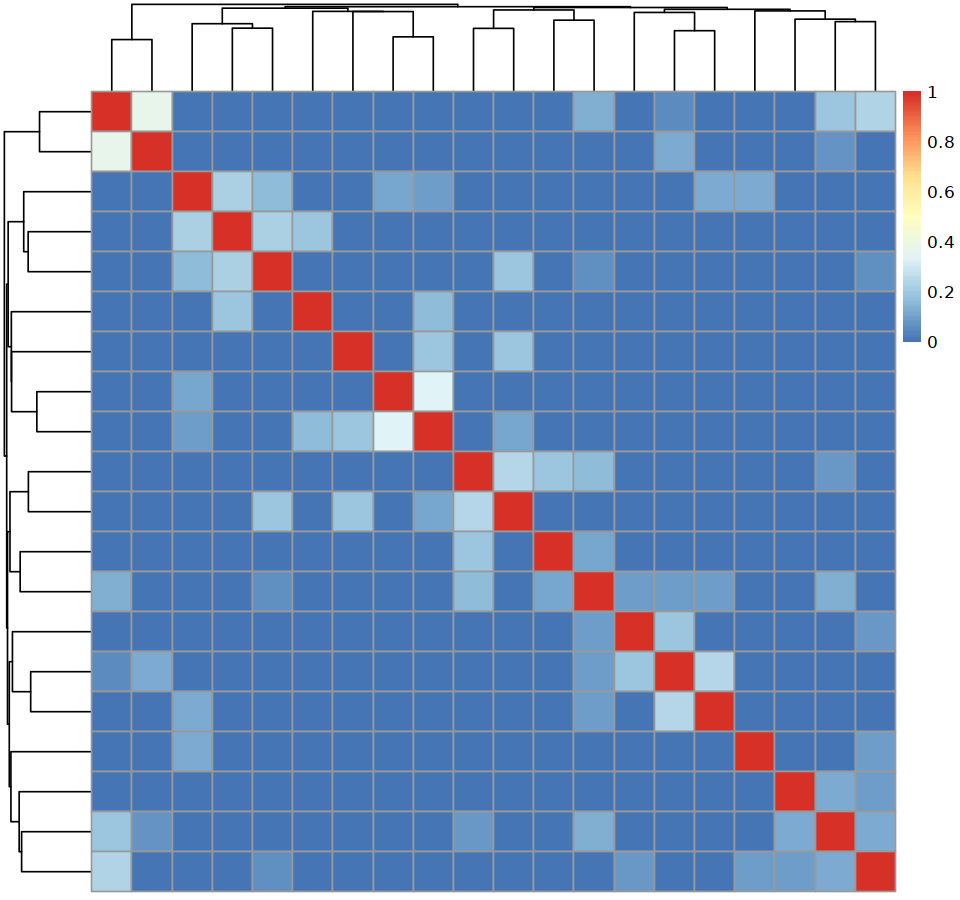

In [61]:
names(res_optima_L) <- names(malignant_list)
 
modules.list <- lapply(res_optima_L, NMFToModules)
 
all = unlist(modules.list, recursive = FALSE, use.names = FALSE)
names(all) = unlist(sapply(modules.list, names))
ta = table(unlist(all))
genes.use = names(ta)[ta > 1]
for (i in 1:5){
  all = unlist(modules.list, recursive = FALSE, use.names = TRUE)
  all = lapply(all, intersect, genes.use)
  sim = sapply(all, function(x){
    sapply(all, function(y){
      length(intersect(x,y))/length(union(x,y))
    })
  })
  keep = rownames(sim)[apply(sim, 1, function(x){
    sum(x > 0.05) >= 3 #大于等于模块数相关的情况，我这里2或3就行
  })]
    print(keep)
  all = all[keep]
  modules.list = lapply(names(modules.list), function(x){
    li = modules.list[[x]]
    li[names(li)[paste(x,names(li),sep='.') %in% keep]]
  })
  names(modules.list) =  names(res_optima_L)
  ta = table(unlist(all))
  genes.use = names(ta)[ta > 1] 
  print(length(all))
}
options(repr.plot.height = 7.5, repr.plot.width = 8)
pheatmap(sim, show_rownames = F, show_colnames = F)

In [65]:
library(igraph)


Attaching package: 'igraph'


The following objects are masked from 'package:NMF':

    algorithm, compare


The following objects are masked from 'package:BiocGenerics':

    normalize, path, union


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union




In [67]:
sub = matrix(0, nrow = length(genes.use), ncol = length(genes.use))
  rownames(sub) = genes.use
  colnames(sub) = genes.use
  for (s in names(modules.list)){
    for (mod in modules.list[[s]]){
      mod = intersect(mod, genes.use)
      for (x in mod){
        for (y in mod){
          sub[x,y] = sub[x,y] + 1
        }
      }
    }
  }
  diag(sub) = 0
adj_keep = sub
# Remove low connections
adj = adj_keep
adj[] = (adj >= 3)
#adj[adj <= 1] = 0
for (i in 1:5){
  keep = names(which(rowSums(adj) >= 5))
  adj = adj[keep,keep]
  print(dim(adj))
}
g = graph_from_adjacency_matrix(adj, diag = FALSE, mode = 'undirected', weighted = TRUE)
modules = communities(cluster_infomap(g, nb.trials = 100))
names(modules) = paste0('m_', sapply(modules, '[', 1))
save(modules,file = "./modules.Rdata")

[1] 0 0
[1] 0 0
[1] 0 0
[1] 0 0
[1] 0 0


ERROR: Error in names(modules) = paste0("m_", sapply(modules, "[", 1)): 'names' attribute [1] must be the same length as the vector [0]


In [66]:


#差异基因GO功能富集分析
library(AnnotationDbi)
library(org.Hs.eg.db)
library(clusterProfiler)
library(dplyr)
library(ggplot2)
#基因ID转换为ENTREZID
for(i in 1:length(modules)){
    modules[[i]] <- bitr(modules[[i]], fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db)
    modules[[i]] <- modules[[i]][,2]
}
#GO富集分析
ego_GO <- list()
for(i in 1:length(modules)){
    ego_GO[[i]] <- enrichGO(gene = modules[[i]],
                    OrgDb = org.Hs.eg.db,
                    keyType = "ENTREZID",
                    ont = "BP", #CC表示细胞组分，MF表示分子功能，BP表示生物学过程，ALL表示同时富集三种过程
                    pAdjustMethod = "BH",
                    minGSSize = 1,
                    pvalueCutoff = 0.01, #通常为0.01或0.05
                    qvalueCutoff = 0.05,
                    readable = TRUE)
    }

[1] 0 0
[1] 0 0
[1] 0 0
[1] 0 0
[1] 0 0


ERROR: Error in names(modules) = paste0("m_", sapply(modules, "[", 1)): 'names' attribute [1] must be the same length as the vector [0]
